# Analyse de la stabilité des segments


Ce notebook a pour but de determiner la fréquence de mise-à-jour (réentrainement) du modèle de segmentation testé et choisi dans le notebook précédent: Kmeans (k=5) sur les feartures de segmentation RFM classique, ainsi que la note moyenne laissé par chaque individu.





---




---



"Bonus": le code étant facilement réutilisable, j'effectue la démarche pour le second modèle KMeans évoqué dans le notebook précédent (k=7, ajout des features de distance moyenne vendeur-acheteur et nombre de paiement).

# Importation des données

In [ ]:
# Connecte le notebook Colab à Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import de librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score, rand_score

!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance,


In [ ]:
# Chargement du dataset
df = pd.read_csv('drive/MyDrive/POlist/df.csv')


In [ ]:
# Fonction d'aggrégation du dataset par individu
def dataset_aggregate(df, start_date, end_date):
    """
    Agrège le DataFrame au customer entre les dates de commandes renseignées.
    Retourne l'id du customer et plusieurs variables agrègées.

    Args:
    - df: DataFrame à agrèger
    - start_date: filtre les commandes passées avant la date
    - end_date: filtre les commandes passées après la date

    Output: DataFrame agrègé au customer
    """

    # convertit les arguments en dates
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Filtre le dataset sur les dates
    df = df[
        (df["order_purchase_timestamp"] >= start_date)
        & (df["order_purchase_timestamp"] <= end_date)
    ]

    # Calcul des features agrègées
    df_agg = df.groupby(["customer_unique_id"], as_index=False, sort=False).agg(
        last_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="max"),
        first_order=pd.NamedAgg(column="order_purchase_timestamp", aggfunc="min"),
        number_orders=pd.NamedAgg(column="order_id", aggfunc="nunique"),
        total_amount=pd.NamedAgg(column="payment_value", aggfunc="sum"),
        average_cart=pd.NamedAgg(column="payment_value", aggfunc="mean"),
        average_price=pd.NamedAgg(column="price", aggfunc="mean"),
        average_qty=pd.NamedAgg(column="order_item_id", aggfunc="mean"),
        average_review_score=pd.NamedAgg(column="review_score", aggfunc="mean"),
        number_reviews=pd.NamedAgg(column="review_comment_message", aggfunc="count"),
        average_payment_sequential=pd.NamedAgg(
            column="payment_sequential", aggfunc="mean"
        ),
        average_payment_installments=pd.NamedAgg(
            column="payment_installments", aggfunc="mean"
        ),
        average_freight_value=pd.NamedAgg(column="freight_value", aggfunc="mean"),
        average_product_weight_g=pd.NamedAgg(column="product_weight_g", aggfunc="mean"),
        average_product_length_cm=pd.NamedAgg(
            column="product_length_cm", aggfunc="mean"
        ),
        average_product_height_cm=pd.NamedAgg(
            column="product_height_cm", aggfunc="mean"
        ),
        average_product_width_cm=pd.NamedAgg(column="product_width_cm", aggfunc="mean"),
        average_distance=pd.NamedAgg(column="distance_km", aggfunc="mean"),
        customer_state=pd.NamedAgg(
            column="customer_state",
            aggfunc=lambda x: np.nan if x.isnull().all() else x.value_counts().index[0],
        ),
        order_different_state=pd.NamedAgg(
            column="order_different_state",
            aggfunc=lambda x: "yes" if x.sum() > 0 else "no",
        ),
        first_payment_type=pd.NamedAgg(
            column="payment_type",
            aggfunc=lambda x: np.nan if x.isnull().all() else x.value_counts().index[0],
        ),
        first_product_category=pd.NamedAgg(
            column="product_category_name_english",
            aggfunc=lambda x: np.nan if x.isnull().all() else x.value_counts().index[0],
        ),
        average_product_name_lenght=pd.NamedAgg(
            column="product_name_lenght", aggfunc="mean"
        ),
        average_product_description_lenght=pd.NamedAgg(
            column="product_description_lenght", aggfunc="mean"
        ),
        average_review_lenght=pd.NamedAgg(
            column="review_comment_message", aggfunc=lambda x: np.mean(x.str.len())
        ),
        average_product_photos_qty=pd.NamedAgg(
            column="product_photos_qty", aggfunc="mean"
        ),
    )

    # Nombre de jours depuis la dernière commande
    df_agg["days_since_last_order"] = end_date - df_agg["last_order"]
    df_agg["days_since_last_order"] = pd.to_numeric(
        df_agg["days_since_last_order"].dt.days, downcast="integer"
    )

    # Taux de review
    df_agg["review_rate"] = df_agg["number_reviews"] / df_agg["number_orders"]

    return df_agg

In [ ]:
import datetime

# Gestion des dates

# colonnes comportant des dates
cols_date = ['order_purchase_timestamp',
             'order_approved_at',
             'order_delivered_carrier_date',
             'order_delivered_customer_date',
             'order_estimated_delivery_date',
             'review_creation_date',
             'review_answer_timestamp',
             'shipping_limit_date']

# convert au bon Dtype et arrondi à la journée
for col in cols_date:
    df[col] = pd.to_datetime(df[col])
    df[col] = df[col].dt.round("D")


# Simulation: features RFM + reviews

Nous nous concentrons d'abord sur le modèle choisi dans le notebook précédent.

## Entrainement initial sur toute l'année 2017

On entraine le premier modèle sur les données de l'année 2017, puis nous réentrainons itérativement le modèle en ajoutant une semaine de données afin de calculer l'ARI avec le premier modèle. L'ARI nous donne une idée de la stabilité du clustering.

In [ ]:
# date début T0
start = '01-01-2017'

# date de fin T0
end_T0 = '31-12-2017'

In [ ]:
# Dataset T0
df_T0 = dataset_aggregate(df, start, end_T0)

# ID client
ID_T0 = df_T0["customer_unique_id"]
df_T0 = df_T0[["days_since_last_order","number_orders","total_amount","average_review_score"]]

In [ ]:
# initiate Standard Scaler
scaler_T0 = StandardScaler()

# fit Standard Scaler T0
scaler_T0.fit(df_T0)

# transform Standard Scaler T0
df_T0_scaled = scaler_T0.transform(df_T0)

# initiate Modèle KMeans 
kmeans_T0 = KMeans(5, random_state=42)

# fit KMeans T0
kmeans_T0.fit(df_T0_scaled)

# predict KMeans T0
clusters_T0 = kmeans_T0.predict(df_T0_scaled)

# reattribue les clusters et ID clients au DF
df_T0['clusters_T0'] = clusters_T0
df_T0['customer_unique_id'] = ID_T0

In [ ]:
# DataFrame à append
data = []
df_ARI = pd.DataFrame(data, columns=['date_fin', 'adjusted_ARI', 'n_multiorders'])

# Génère une liste de date par steps d'une semaine
end_dates = pd.date_range(start="2018-01-01",end="2018-04-01", freq="W").to_pydatetime().tolist()

In [ ]:
# Intère sur les dates

for date in end_dates:
    # date de fin Tn
    end_Tn = date

    # Dataset T+n
    df_Tn = dataset_aggregate(df, start, end_Tn)
    ID_Tn = df_Tn["customer_unique_id"]
    df_Tn = df_Tn[["days_since_last_order","number_orders","total_amount","average_review_score"]]

    # transform Standard Scaler T0 sur T+n
    df_Tn_scaled = scaler_T0.transform(df_Tn)

    # predict KMeans T0 sur T+n
    clusters_Tn = kmeans_T0.predict(df_Tn_scaled)
    df_Tn['clusters_Tn'] = clusters_Tn
    df_Tn['customer_unique_id'] = ID_Tn

    # join
    df_final = df_T0[['customer_unique_id','clusters_T0']].merge(
                      df_Tn[['customer_unique_id','clusters_Tn']], on='customer_unique_id', how='left')

    # ARI T0 x T+n
    ARI_adj = adjusted_rand_score(df_final['clusters_T0'], df_final['clusters_Tn'])
    ARI = rand_score(df_final['clusters_T0'], df_final['clusters_Tn'])

    # nombre de clients
    n_clients = len(df_Tn)

    # nombre de clients ayant effectué plusieurs commandes sur la periode
    n_multiorders = len(df_Tn[df_Tn['number_orders'] > 1])

    # append DataFrame
    new_row = {'date_fin':end_Tn, 'ARI':ARI, 'adjusted_ARI':ARI_adj, 'n_clients':n_clients, 'n_multiorders':n_multiorders}

    df_ARI = df_ARI.append(new_row, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
df_ARI

,date_fin,adjusted_ARI,n_multiorders,ARI,n_clients
0,2018-01-07,0.938025,1139,0.972175,41993.0
1,2018-01-14,0.876103,1180,0.944465,43598.0
2,2018-01-21,0.812913,1235,0.916195,45215.0
3,2018-01-28,0.759611,1282,0.892281,46683.0
4,2018-02-04,0.707712,1327,0.868822,48103.0
5,2018-02-11,0.660377,1381,0.847257,49576.0
6,2018-02-18,0.607421,1438,0.822797,51022.0
7,2018-02-25,0.562785,1497,0.801791,52607.0
8,2018-03-04,0.521177,1565,0.781785,54323.0
9,2018-03-11,0.483253,1614,0.763075,55826.0


(array([736709., 736726., 736740., 736754., 736768., 736785.]),
 <a list of 6 Text major ticklabel objects>)

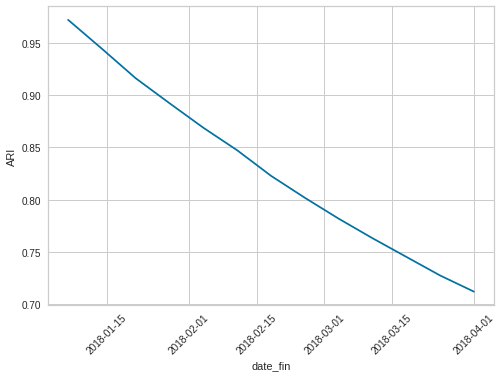

In [ ]:
sns.lineplot(x='date_fin', y='ARI', data=df_ARI)
plt.xticks(rotation=45)

(array([736709., 736726., 736740., 736754., 736768., 736785.]),
 <a list of 6 Text major ticklabel objects>)

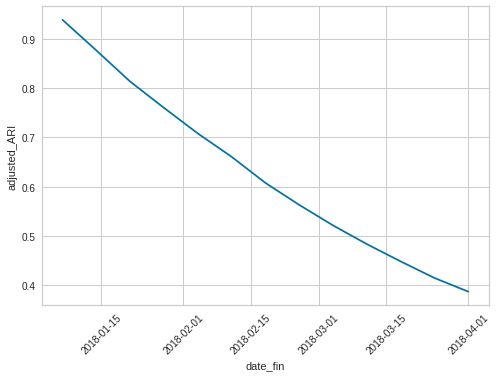

In [ ]:
sns.lineplot(x='date_fin', y='adjusted_ARI', data=df_ARI)
plt.xticks(rotation=45)

(array([736709., 736726., 736740., 736754., 736768., 736785.]),
 <a list of 6 Text major ticklabel objects>)

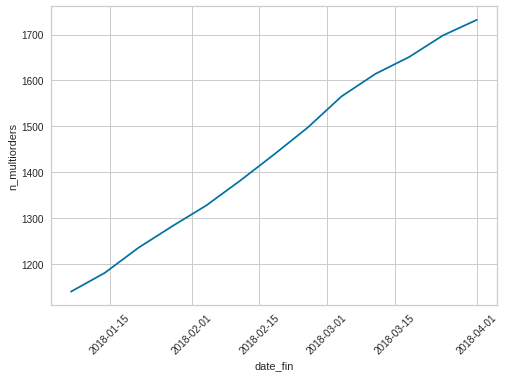

In [ ]:
sns.lineplot(x='date_fin', y='n_multiorders', data=df_ARI)
plt.xticks(rotation=45)

(array([736709., 736726., 736740., 736754., 736768., 736785.]),
 <a list of 6 Text major ticklabel objects>)

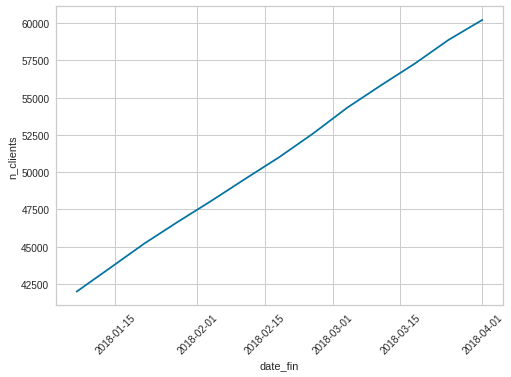

In [ ]:
sns.lineplot(x='date_fin', y='n_clients', data=df_ARI)
plt.xticks(rotation=45)

L'ARI et l'ARI ajusté diminuent de manière linéaire au fil des semaines:
- l'ARI passe sous le seuil de 0.8 après 2 mois et 3 semaines
- l'ARI ajusté passe sous le seuil de 0.8 après un mois et deux semaines

## Entrainement initial de Janvier 2017 à Avril 2018

In [ ]:
# date début T0
start = '01-01-2017'

# date de fin T0
end_T0 = '30-04-2018'

In [ ]:
# Dataset T0
df_T0 = dataset_aggregate(df, start, end_T0)

# ID client
ID_T0 = df_T0["customer_unique_id"]
df_T0 = df_T0[["days_since_last_order","number_orders","total_amount","average_review_score"]]

In [ ]:
# initiate Standard Scaler
scaler_T0 = StandardScaler()

# fit Standard Scaler T0
scaler_T0.fit(df_T0)

# transform Standard Scaler T0
df_T0_scaled = scaler_T0.transform(df_T0)

# initiate Modèle KMeans 
kmeans_T0 = KMeans(5, random_state=42)

# fit KMeans T0
kmeans_T0.fit(df_T0_scaled)

# predict KMeans T0
clusters_T0 = kmeans_T0.predict(df_T0_scaled)

# reattribue les clusters et ID clients au DF
df_T0['clusters_T0'] = clusters_T0
df_T0['customer_unique_id'] = ID_T0

In [ ]:
# DataFrame à append
data = []
df_ARI = pd.DataFrame(data, columns=['date_fin', 'adjusted_ARI', 'n_multiorders'])

# Génère une liste de date par steps d'une semaine
end_dates = pd.date_range(start="2018-05-01",end="2018-08-31", freq="W").to_pydatetime().tolist()

In [ ]:
# Intère sur les dates

for date in end_dates:
    # date de fin Tn
    end_Tn = date

    # Dataset T+n
    df_Tn = dataset_aggregate(df, start, end_Tn)
    ID_Tn = df_Tn["customer_unique_id"]
    df_Tn = df_Tn[["days_since_last_order","number_orders","total_amount","average_review_score"]]

    # transform Standard Scaler T0 sur T+n
    df_Tn_scaled = scaler_T0.transform(df_Tn)

    # predict KMeans T0 sur T+n
    clusters_Tn = kmeans_T0.predict(df_Tn_scaled)
    df_Tn['clusters_Tn'] = clusters_Tn
    df_Tn['customer_unique_id'] = ID_Tn

    # join
    df_final = df_T0[['customer_unique_id','clusters_T0']].merge(
                      df_Tn[['customer_unique_id','clusters_Tn']], on='customer_unique_id', how='left')

    # ARI T0 x T+n
    ARI_adj = adjusted_rand_score(df_final['clusters_T0'], df_final['clusters_Tn'])
    ARI = rand_score(df_final['clusters_T0'], df_final['clusters_Tn'])

    # nombre de clients
    n_clients = len(df_Tn)

    # nombre de clients ayant effectué plusieurs commandes sur la periode
    n_multiorders = len(df_Tn[df_Tn['number_orders'] > 1])

    # append DataFrame
    new_row = {'date_fin':end_Tn, 'ARI':ARI, 'adjusted_ARI':ARI_adj, 'n_clients':n_clients, 'n_multiorders':n_multiorders}

    df_ARI = df_ARI.append(new_row, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
df_ARI

,date_fin,adjusted_ARI,n_multiorders,ARI,n_clients
0,2018-05-06,0.966717,1946,0.985178,67902.0
1,2018-05-13,0.926813,2008,0.967473,69733.0
2,2018-05-20,0.885305,2059,0.949108,71496.0
3,2018-05-27,0.849710,2097,0.933375,72428.0
4,2018-06-03,0.817271,2129,0.919026,73398.0
5,2018-06-10,0.777446,2187,0.901407,74734.0
6,2018-06-17,0.736124,2225,0.883060,76206.0
7,2018-06-24,0.675985,2271,0.856185,77527.0
8,2018-07-01,0.609456,2313,0.826002,78881.0
9,2018-07-08,0.566340,2347,0.806017,80045.0


(array([736815., 736829., 736846., 736860., 736876., 736890., 736907.,
        736921.]), <a list of 8 Text major ticklabel objects>)

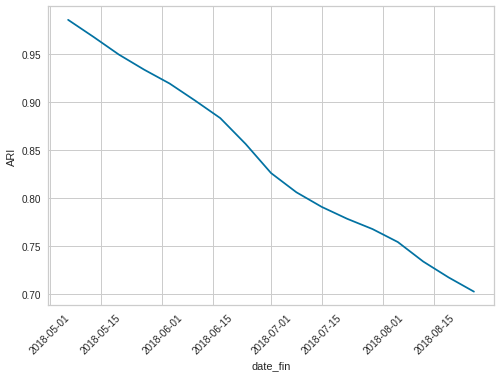

In [ ]:
sns.lineplot(x='date_fin', y='ARI', data=df_ARI)
plt.xticks(rotation=45)

(array([736815., 736829., 736846., 736860., 736876., 736890., 736907.,
        736921.]), <a list of 8 Text major ticklabel objects>)

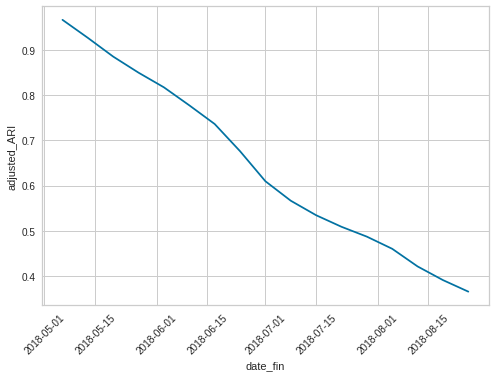

In [ ]:
sns.lineplot(x='date_fin', y='adjusted_ARI', data=df_ARI)
plt.xticks(rotation=45)

(array([736815., 736829., 736846., 736860., 736876., 736890., 736907.,
        736921.]), <a list of 8 Text major ticklabel objects>)

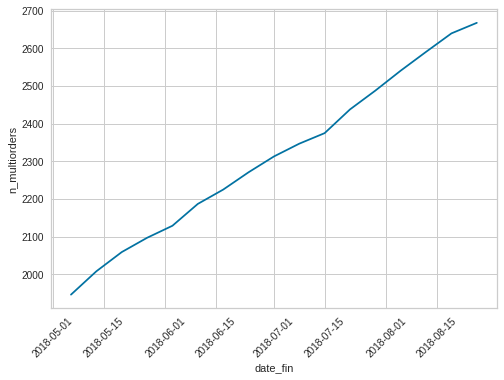

In [ ]:
sns.lineplot(x='date_fin', y='n_multiorders', data=df_ARI)
plt.xticks(rotation=45)

(array([736815., 736829., 736846., 736860., 736876., 736890., 736907.,
        736921.]), <a list of 8 Text major ticklabel objects>)

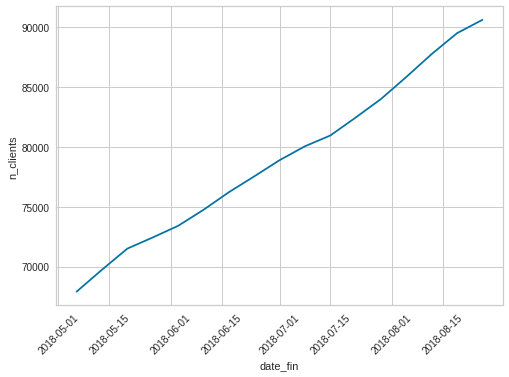

In [ ]:
sns.lineplot(x='date_fin', y='n_clients', data=df_ARI)
plt.xticks(rotation=45)

L'ARI et l'ARI ajusté diminuent là encore de manière linéaire au fil des semaines:
- l'ARI passe sous le seuil de 0.8 après 2 mois et 1 semaine
- l'ARI ajusté passe sous le seuil de 0.8 après un mois et une semaine

**-> Je conseillerais une fréquence de misa-à-jour de la segmentation de deux mois pour ce modèle**

# Simulation: features RFM + reviews + distance + payment installments

On répète la démarche sur le second modèle intégrant plus de features.

## Entrainement initial de Janvier 2017 à Avril 2018

In [ ]:
# date début T0
start = '01-01-2017'

# date de fin T0
end_T0 = '30-04-2018'

In [ ]:
# Dataset T0
df_T0 = dataset_aggregate(df, start, end_T0)

# ID client
ID_T0 = df_T0["customer_unique_id"]
df_T0 = df_T0[["days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
                "average_distance",
                "average_payment_installments",]]

In [ ]:
# initiate Standard Scaler
scaler_T0 = StandardScaler()

# fit Standard Scaler T0
scaler_T0.fit(df_T0)

# transform Standard Scaler T0
df_T0_scaled = scaler_T0.transform(df_T0)

# initiate Modèle KMeans 
kmeans_T0 = KMeans(7, random_state=42)

# fit KMeans T0
kmeans_T0.fit(df_T0_scaled)

# predict KMeans T0
clusters_T0 = kmeans_T0.predict(df_T0_scaled)

# reattribue les clusters et ID clients au DF
df_T0['clusters_T0'] = clusters_T0
df_T0['customer_unique_id'] = ID_T0

In [ ]:
# DataFrame à append
data = []
df_ARI = pd.DataFrame(data, columns=['date_fin', 'adjusted_ARI', 'n_multiorders'])

# Génère une liste de date par steps d'une semaine
end_dates = pd.date_range(start="2018-05-01",end="2018-08-31", freq="W").to_pydatetime().tolist()

In [ ]:
# Intère sur les dates

for date in end_dates:
    # date de fin Tn
    end_Tn = date

    # Dataset T+n
    df_Tn = dataset_aggregate(df, start, end_Tn)
    ID_Tn = df_Tn["customer_unique_id"]
    df_Tn = df_Tn[["days_since_last_order",
                "number_orders",
                "total_amount",
                "average_review_score",
                "average_distance",
                "average_payment_installments"]]

    # transform Standard Scaler T0 sur T+n
    df_Tn_scaled = scaler_T0.transform(df_Tn)

    # predict KMeans T0 sur T+n
    clusters_Tn = kmeans_T0.predict(df_Tn_scaled)
    df_Tn['clusters_Tn'] = clusters_Tn
    df_Tn['customer_unique_id'] = ID_Tn

    # join
    df_final = df_T0[['customer_unique_id','clusters_T0']].merge(
                      df_Tn[['customer_unique_id','clusters_Tn']], on='customer_unique_id', how='left')

    # ARI T0 x T+n
    ARI_adj = adjusted_rand_score(df_final['clusters_T0'], df_final['clusters_Tn'])
    ARI = rand_score(df_final['clusters_T0'], df_final['clusters_Tn'])

    # nombre de clients
    n_clients = len(df_Tn)

    # nombre de clients ayant effectué plusieurs commandes sur la periode
    n_multiorders = len(df_Tn[df_Tn['number_orders'] > 1])

    # append DataFrame
    new_row = {'date_fin':end_Tn, 'ARI':ARI, 'adjusted_ARI':ARI_adj, 'n_clients':n_clients, 'n_multiorders':n_multiorders}

    df_ARI = df_ARI.append(new_row, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
df_ARI

,date_fin,adjusted_ARI,n_multiorders,ARI,n_clients
0,2018-05-06,0.970553,1946,0.989610,67902.0
1,2018-05-13,0.935928,2008,0.977469,69733.0
2,2018-05-20,0.898954,2059,0.964556,71496.0
3,2018-05-27,0.867281,2097,0.953525,72428.0
4,2018-06-03,0.837686,2129,0.943208,73398.0
5,2018-06-10,0.803765,2187,0.931369,74734.0
6,2018-06-17,0.765161,2225,0.917820,76206.0
7,2018-06-24,0.716760,2271,0.900642,77527.0
8,2018-07-01,0.670046,2313,0.883724,78881.0
9,2018-07-08,0.632738,2347,0.869858,80045.0


(array([736815., 736829., 736846., 736860., 736876., 736890., 736907.,
        736921.]), <a list of 8 Text major ticklabel objects>)

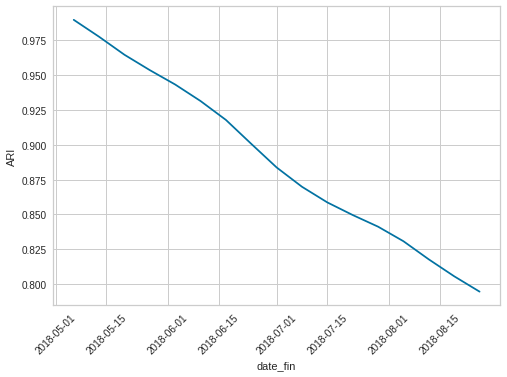

In [ ]:
sns.lineplot(x='date_fin', y='ARI', data=df_ARI)
plt.xticks(rotation=45)

(array([736815., 736829., 736846., 736860., 736876., 736890., 736907.,
        736921.]), <a list of 8 Text major ticklabel objects>)

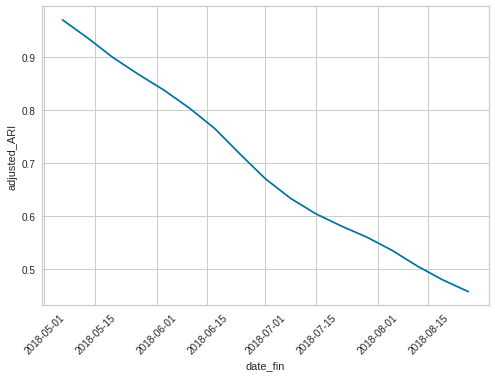

In [ ]:
sns.lineplot(x='date_fin', y='adjusted_ARI', data=df_ARI)
plt.xticks(rotation=45)

(array([736815., 736829., 736846., 736860., 736876., 736890., 736907.,
        736921.]), <a list of 8 Text major ticklabel objects>)

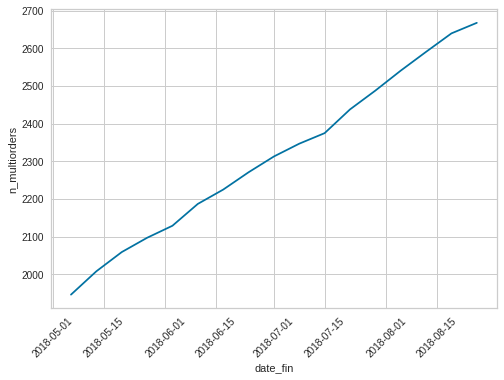

In [ ]:
sns.lineplot(x='date_fin', y='n_multiorders', data=df_ARI)
plt.xticks(rotation=45)

(array([736815., 736829., 736846., 736860., 736876., 736890., 736907.,
        736921.]), <a list of 8 Text major ticklabel objects>)

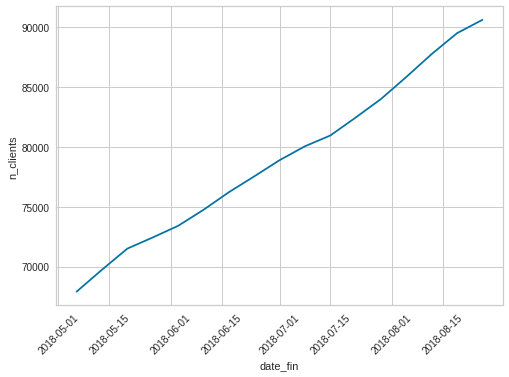

In [ ]:
sns.lineplot(x='date_fin', y='n_clients', data=df_ARI)
plt.xticks(rotation=45)

L'ARI et l'ARI ajusté diminuent là encore de manière linéaire au fil des semaines:
- l'ARI passe sous le seuil de 0.8 après 3 mois et 2 semaines
- l'ARI ajusté passe sous le seuil de 0.8 après un mois et 3 semaines

**-> Je conseillerais une fréquence de mise-à-jour de la segmentation de trois mois pour ce modèle**